<a href="https://colab.research.google.com/github/saarangp/dreammachines/blob/main/Sparse_Coding_Dream_Machines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sparse Coding Dream Machines

Saarang Panchavati, Henry Allen, Abhinav Pottabathula, Ashwath Radhachandran

Welcome to our final project for [VS265 Fall 2020](https://redwood.berkeley.edu/courses/vs265/)!

## Overview
In 1983, Crick and Mitchison proposed a theory of REM sleep, where the purpose of dreams is hypothesized to be to “unlearn,” or to remove unnecessary connections between neurons in a neural network. One such mathematical and computational formalism of this is the wake-sleep algorithm [1], which aims to recreate this biological idea through an dual phase unsupervised learning algorithm. In the sleep phase, we aim to strengthen generative connections between increasingly abstract layers. That is, from the layer of most abstraction, we aim to generate weights that can generate the representation of the next most abstract layer. The output of this “sleep phase” can be viewed as a “dream.” We are interested in visualizing these “dreams” to see how a wake sleep model may create a representation of natural images. To make this more biologically relevant, instead of directly training a wake sleep model on natural images, we will train it on a sparse coding representation of natural images. This additional abstraction and sparsity may give us very fascinating insights into how we learn, and how we dream. **To sum up, we trained a sparse coding representation of natural images, using that representation to train a wake sleep model, and decoding and visualizing the generative sparse codes of the sleep phase.**

## In this Notebook:

You will be able to play with our implementation of Sparse Coding Dream Machines! You can: 


*   Load a dataset of your choice from [TFDS](https://www.tensorflow.org/datasets/catalog/overview) (we have some suggestions!) or [sklearn datasets](https://scikit-learn.org/stable/datasets/index.html)
*   Use the data to learn a sparse coding feature set
*   Visualize the activation maps of the sparse coding model
*   Feed these activations into a Helmholtz machine, and visualize the model's dreams as it learns a representation! 
*   **Note:** All the code is hidden, but if you double click on the cells, you'll see the code and will be able to modify it if you choose! 

All the code can be found [here](https://github.com/saarangp/dreammachines), and feel free to reach out with any questions! 





## Imports and Loading Model

Just run the cell below by pressing the `play` button! You can also run cells with `shift + enter`

In [2]:
#@title {display-mode: 'form'}
#@markdown We will load our Helmholtz Model from the [repo](https://github.com/saarangp/dreammachines), and import the helmholtz class as `hm`, and import the necessary classes to conduct Sparse Coding


import numpy as np
import tensorflow as tf 
import os
import tensorflow_datasets as tfds
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
import IPython
from IPython.display import Image
from sklearn.datasets import fetch_olivetti_faces




if "dreammachines" not in os.listdir():
  !git clone https://github.com/saarangp/dreammachines

from dreammachines import helmholtz as hm
from dreammachines.sparse_coding import calc_LCA, calc_Phi, SparseCodingModel


Cloning into 'dreammachines'...
remote: Enumerating objects: 177, done.
remote: Counting objects: 100% (177/177), done.
remote: Compressing objects: 100% (132/132), done.
remote: Total 177 (delta 97), reused 107 (delta 42), pack-reused 0
Receiving objects: 100% (177/177), 8.57 MiB | 11.82 MiB/s, done.
Resolving deltas: 100% (97/97), done.


## Load Data of Choice

mnist


,image,label
0,,2
1,,0
2,,4
3,,8


1it [00:00,  8.15it/s]

Image Shape:  (28, 28)
Flattened Image Shape  784


10000it [00:03, 2519.66it/s]


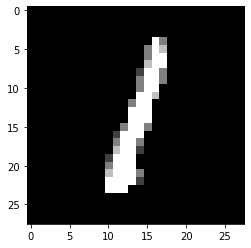

In [7]:
#@title Select which dataset to use! {display-mode: 'form'}
#@markdown **just press the play button to run this cell!**
#@markdown You can also select how many images to use in the training, we recommend a max of 100 for the sake of time, but feel free to go nuts. The images will be stored in an array called `images`. We automatically selected a particular class to train on for the TFDS datasets (for example only the ones in MNIST). On the `faces` dataset, we also perform some basic preprocessing to make it better for learning. 
dataset = "mnist" #@param ["sklearn faces", "mnist", "fashion_mnist"]
num_images = 30 #@param {type:"slider", min:10, max:100, step:1}

def contrast_images(images):
    return images**2

def undo_contrast_images(images):
    return np.sqrt(images)

def blur_images(images, scale=3):
    return np.array([ndimage.gaussian_filter(img, scale) for img in images])
    
def sharpen_images(images, scale=5):
    return np.array([img + scale * (img - ndimage.gaussian_filter(img, 1)) for img in images])

def get_face_images(num_images=5):
    faces, _ = fetch_olivetti_faces(return_X_y=True, shuffle=True)
    n_samples, n_features = faces.shape
    image_shape = (64, 64)
    # global centering
    faces_centered = faces - faces.mean(axis=0)
    # local centering
    faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)
    flat_im_shape = image_shape[0]*image_shape[1]
    plt.imshow(faces_centered[0].reshape(image_shape), cmap = 'gray')
    if max(faces_centered[0]) > 1:
      faces_centered = faces_centered/255
    return faces_centered[:num_images], image_shape, flat_im_shape

def get_tfds(dataset, num_images):
  data_name = dataset
  print(dataset)
  split = f'test' #choose the smaller split please
  ds, info = tfds.load(data_name, split=split, with_info=True, try_gcs=True)
  display(tfds.as_dataframe(ds.take(4), info))
  for e in ds.take(1):
    im_shape = (e['image'].shape[0], e['image'].shape[1])
  flat_im_shape = im_shape[0]*im_shape[1]
  print("Image Shape: ", im_shape)
  print("Flattened Image Shape ", flat_im_shape)
  images = []
  labels = []
  for item in tqdm(tfds.as_numpy(ds)):
    image = item['image']
    if image.shape[2] != 1:
      image = tf.image.rgb_to_grayscale(image).numpy()
    image = image[:,:,0].reshape(flat_im_shape)
    label = item['label']
    images.append(image)
    labels.append(label)

  images = np.array(images)
  labels = np.array(labels)
  plt.imshow(images[0].reshape(im_shape), cmap = 'gray')
  images = images[labels == 1] #None
  plt.imshow(images[0].reshape(im_shape), cmap = 'gray')
  if max(images[0]) > 1:
    images = images/255
  return images[:num_images], im_shape, flat_im_shape

if dataset == 'sklearn faces':
  images, image_shape, flat_im_shape = get_face_images(num_images)
else:
  images, image_shape, flat_im_shape = get_tfds(dataset, num_images)

## Sparse Coding

Now lets use our images to create a Sparse Coding Model! 

Here's some more informatation about Sparse Coding if you are interested! If not, feel free to move on to take a look at what it does. 

### Sparse Coding Overview
A key development in our understanding of visual neural networks has been the use of sparse coding models. Sparse models provide a trade-off between traditional neural networks with dense representations of data and grandmother cell networks, where a single cell represents a single input, i.e. a single neuron might represent all things Jennifer Aniston. The single cell network is obviously brittle to change and incredibly space inefficient, but we do have reason to think that there might be some of this sparsity in certain visual networks. This sparsity allows for certain interpretable features to be encoded by a small network of cells, as we see in the oriented simple cells in V1. These simple cells represent spatial frequency patches of different orientations and sizes. If we have to represent an image patch with hundreds of these patches, it seems like we would waste a lot of cortical area, as we could likely represent an image more densely. However, this density would come at the expense of interpretability in more abstract networks. It seems clear that our brain has an incredibly modularized structure, which seems unachievable by dense networks in most circumstances. We will initially build a sparse coding feature set by training on natural image sets. We will implement the sparse coding model as described in lecture [3]. We want to use the sparse coding model generativelly, i.e. we use the feature library it learns to generate images. We will also use it to learn the activations for images, and investigate if we can use these activations to enforce sparsity in higher levels of abstraction in a neural network, similar to how our visual system might work.


In [8]:
#@title Configure Parameters for Sparse Coding! 
#@markdown Feel free to leave this as default and just hit run! 
alpha = 0.01 #@param {type:"slider", min:0.001, max:0.1, step:0.01}
n_activations = 32 #@param {type:"slider", min:10, max:50, step:1}
num_steps = 10 #@param {type:"slider", min:0, max:20, step:1}
do_contrast = False #@param {type:"boolean"}
do_sharpen = False #@param {type:"boolean"}
do_blur = False #@param {type:"boolean"}

# n_activations = 32
# alpha = 0.01
# num_steps = 10
test_train_ratio = .8

# The following are useful/necessary to find proper sparse codes
# do_contrast = True
# do_sharpen = False
# do_blur = False

In [9]:
#@title Now let's train our sparse coding model! {display-mode: 'form'}
input_size = flat_im_shape
train_images = images
if (do_contrast):
    train_images = contrast_images(images)
if (do_sharpen):
    train_images = sharpen_images(images)
if (do_blur):
    train_images = blur_images(images) 
  
test_train_split = int(num_images*test_train_ratio)
X_train, X_test = train_images[:test_train_split], train_images[test_train_split:]

model = SparseCodingModel(input_size, n_activations, alpha)
model.train(X_train, alpha, num_steps)

100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


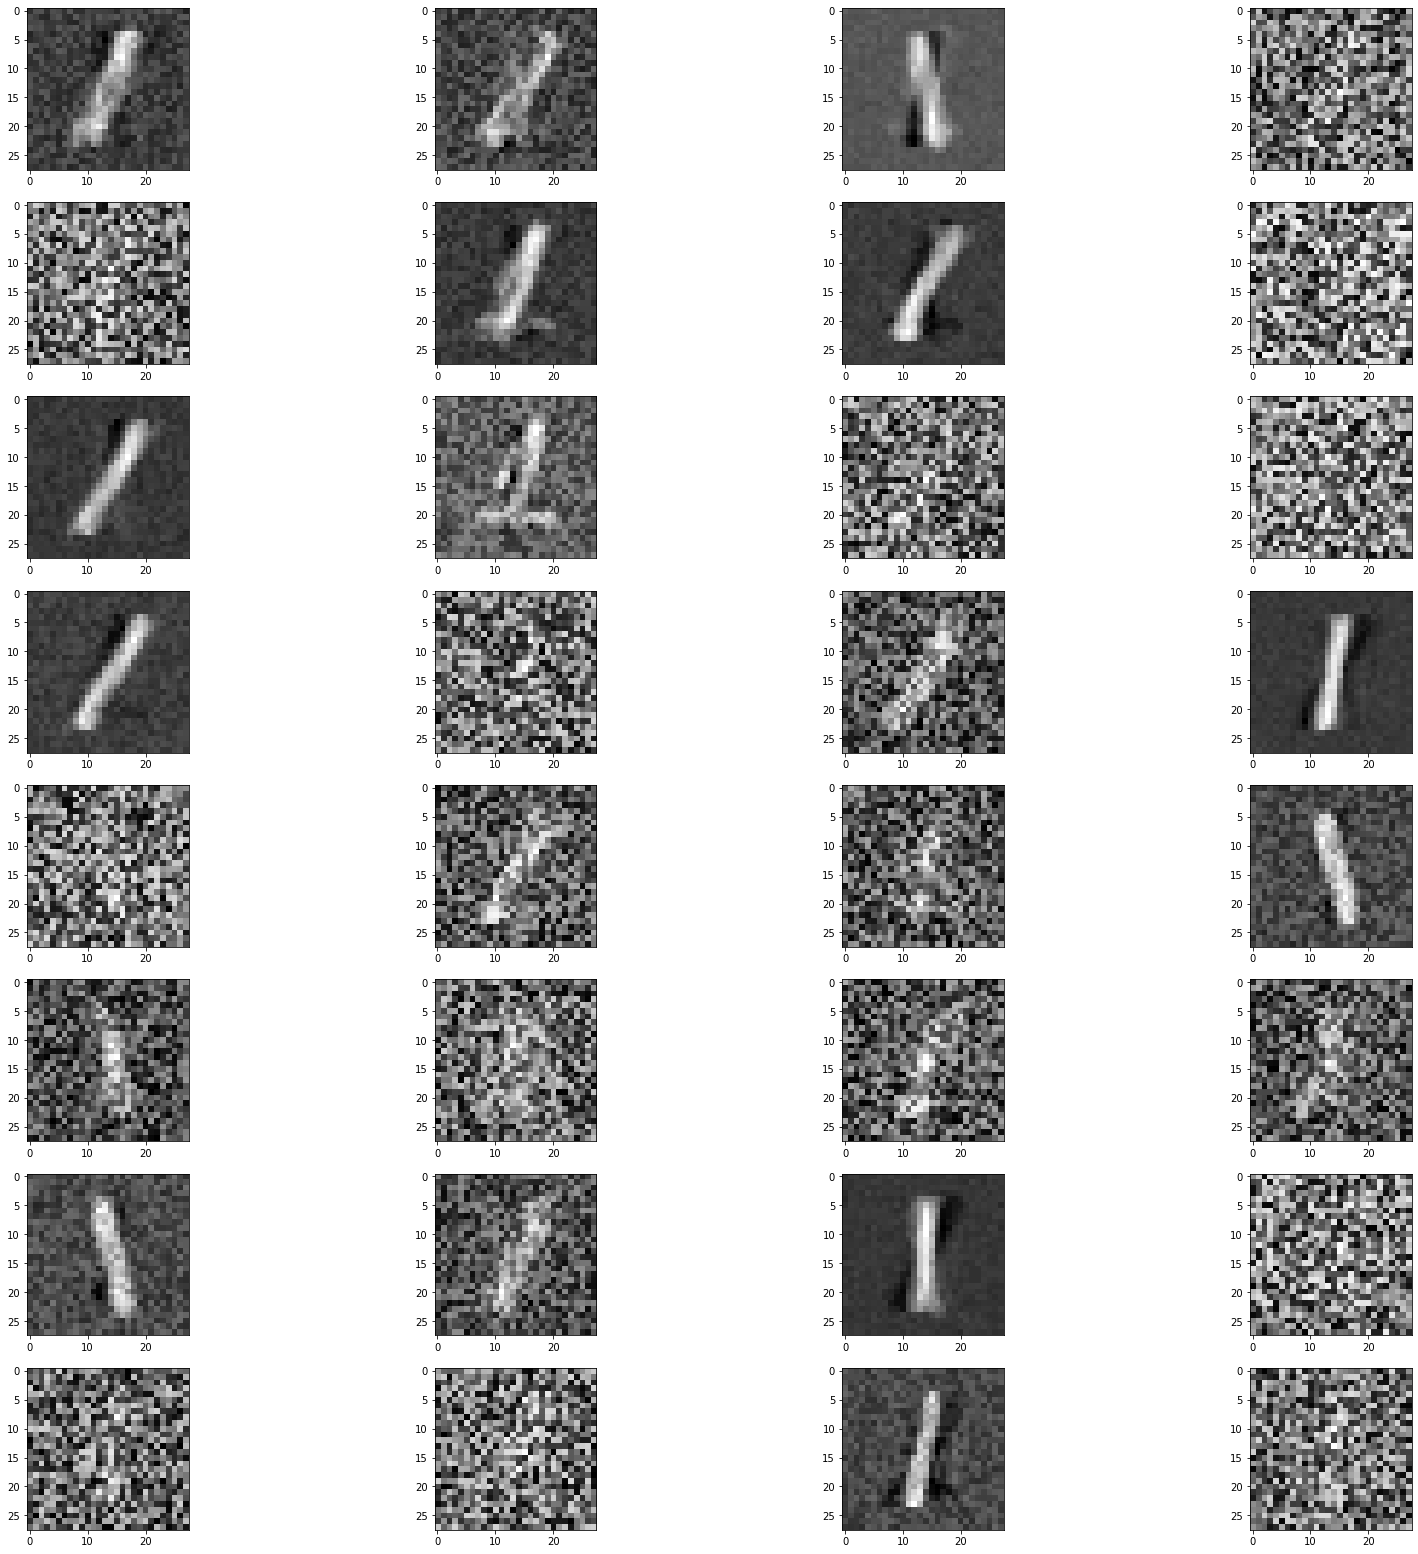

In [10]:
#@title We can now take a look at what our feature library looks like
#@markdown depending on your images, and how many you used, we'll get better or worse representation of our image set

fig=plt.figure(figsize=image_shape)
columns = 4
rows = 8
for i in range(n_activations):
    img = model.Phi[:, i].reshape(image_shape)
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(img, cmap='gray')
plt.show()


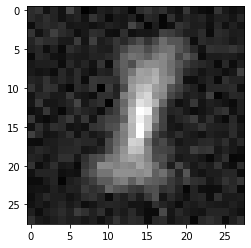

In [11]:
#@title While we're at it...
#@markdown we can also take a look at what an images composed of these learned features might look like. Kinda spooky 👻 
activations = model.predict(X_train, num_steps=num_steps)
X_pred = model.generate(activations)
if (do_contrast):
    X_pred = undo_contrast_images(X_pred)
    X_test = undo_contrast_images(X_test)
if (do_sharpen):
    #TODO: May need fixing
    X_pred = blur_images(images)
    X_test = blur_images(images)
if (do_blur):
    #TODO: May need fixing
    X_pred = sharpen_images(images)
    X_test = sharpen_images(images)
plt.imshow(X_pred[:,0].reshape(image_shape), cmap='gray');


## Wake-Sleep Model

Now lets explore how we can train a `Helmholtz Machine`, a particular type of model that trains with the wake sleep model to generate _dreams_ based on our sparse coding representation

### Overview of Wake-Sleep and Helmholtz
One method of implementing the wake-sleep algorithm is through a Helmholtz machine. As outlined in Hinton’s paper, a three-layer Helmholtz machine was effective in generating “fantasies” of handwritten digits [2]. In this example, a separate network was trained for each digit and then fantasies were generated for each of the digits based off of the respective model. In our case, we aim to train one network based on the features that our sparse coding model has extracted and then see if the network can generate an interpretable image. 

In our implementation, each image has 1000 wake sleep iterations, and thus 1000 dreams.





---


First, lets take a second to explore what the wake sleep model does on the raw images (not on the sparse codes learned for the dataset). We'll do it with 1 data point, so don't expect it to learn a particularly good representation with sensible dreams, but you should see something that resembles what our data looks like!

  0%|          | 0/1 [00:00<?, ?it/s]

Using the following Layer Sizes [784, 32]
(784, 32)
(32, 1)


100%|██████████| 10/10 [00:00<00:00, 360.51it/s]


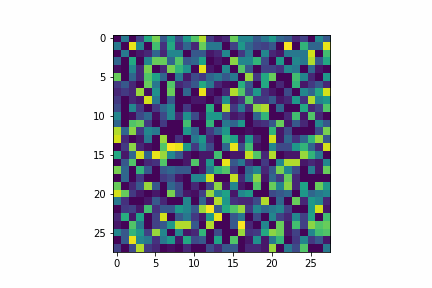

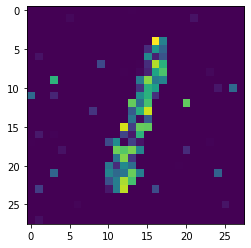

In [ ]:
#@title Lets set some parameters, and see what our dreams look like! {display-mode: "form"}
#@markdown Enter the Learning rate, and the layer sizes you want as a comma separated list like `64, 32`
learning_rate = .1 #@param {type:"slider", min:0.01, max:0.1, step:0.01}
layer_sizes = "32" #@param {type:"string"}

sizes = [int(l.strip()) for l in layer_sizes.split(",")]
layer_sizes = [flat_im_shape]
layer_sizes.extend(sizes)
print("Using the following Layer Sizes", layer_sizes)

h = hm.helmholtz(layer_sizes, 'beta', learning_rate) 
for image in tqdm(images[:1]):
  h.train(image.reshape(1,-1))
  
dreams = h.dreams
frames = [] # for storing the generated images
fig = plt.figure()
for dream in tqdm(dreams[::100]):
    dream = dream.reshape(image_shape)
    frames.append([plt.imshow(dream,animated=True)]);


ani = animation.ArtistAnimation(fig, frames, interval=10, blit=True)
ani.save('dreaming.gif',writer=animation.PillowWriter())
Image(open('dreaming.gif','rb').read())

### With Sparse Coding

Now lets examine how our wake sleep model does with the learned sparse feature activations rather than the raw images. This is potentially a more accurate way of modeling how the brain may undergo similar processes. 

**Disclaimer**: what we've implemented here is nowhere close to how the brain actually operates, just inspired some ideas about how it _may_ work

In [ ]:
#@title Now with Sparse Coding {display-mode: 'form'}
#@markdown Now lets examine how our wake sleep model does with the learned sparse feature activations rather than the raw images. This is potentially a more accurate way of modeling how the brain may undergo similar processes. <br> **Disclaimer**: what we've implemented here is nowhere close to how the brain actually operates, just inspired some ideas about how it _may_ work

new_layer_sizes = [n_activations]
new_layer_sizes.append(layer_sizes.pop())
print("Using the following layer sizes", new_layer_sizes)
h = hm.helmholtz(new_layer_sizes, 'beta', learning_rate)

for i in tqdm(range(test_train_split)):
    h.train(activations[:, i].reshape(1, -1))

  0%|          | 0/24 [00:00<?, ?it/s]

Using the following layer sizes [32, 32]
(32, 32)
(32, 1)


100%|██████████| 24/24 [00:06<00:00,  3.55it/s]







  0%|          | 0/80 [00:00<?, ?it/s]




100%|██████████| 80/80 [00:00<00:00, 667.27it/s]


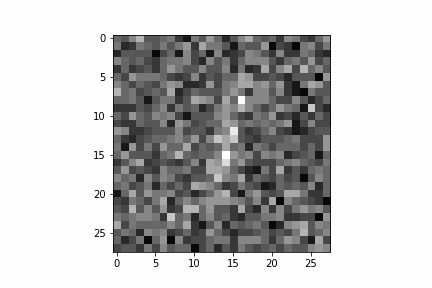

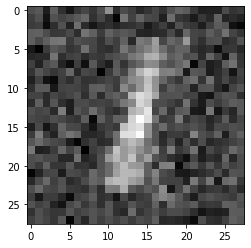

In [ ]:
#@title What do our sparse decoded dreams look like? 
#@markdown Moment of Truth! Let's take a look at how our dreams that have been trained on sparse code feature activations and decoded look like! 

dreams = h.dreams
frames = [] # for storing the generated images
fig = plt.figure()
for dream in tqdm(dreams[::100]):
    dream = model.generate(dream).reshape(image_shape)
    frames.append([plt.imshow(dream,cmap = 'gray',animated=True)])

ani = animation.ArtistAnimation(fig, frames, interval=10, blit=True)
ani.save('sparse_coding_dreaming.gif',writer=animation.PillowWriter())
Image(open('sparse_coding_dreaming.gif','rb').read())

Hopefully the dreams look like something that resembles the input data! If not, try again with some modifications of the parameters (more images, lower learning rate). At this time, the gifs of dreams are 10 "dreams" per image or activation map. If you want only the dreams for a particular image, feel free to modify the above code to save the dreams. 

## Conclusion

**TODO Conclusion from Paper**